In [1]:
import os
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import pandas as pd
import xarray as xr
import tensorflow as tf
import wandb 

from coldpooling.cp_detection_timeseries import cp_detection as cpdt


from coldpooling.data_loader import load_datasets,load_and_average_dataset, find_cps, sample_indices_3sets, create_windows
from coldpooling.model import compile_and_fit,define_models,get_model,plot_variable_importance,plot_model_performance,plot_loss




2024-03-18 09:51:04.490670: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
IN_WIDTH=12
OUT_STEPS=6
SHIFT=2


In [3]:
fp='datasets/'
file1min = fp+'station_output.nc'
fileAveraged = fp+'WRF-10min.csv'
ds1min, dfAveraged = load_datasets(file1min,fileAveraged)
ds1min, dfAveraged = load_datasets(file1min,fileAveraged)

#ds1min, dfAveraged = load_and_average_dataset(file1min,averaging_interval='10min')

dfAveraged

,T2__Pout,RAIN_1MIN__Pout,Q2__Pout,SMOIS__Pout,U10__Pout,V10__Pout,PSFC__Pout,lat__Pout,lon__Pout,T2__Dakar,RAIN_1MIN__Dakar,Q2__Dakar,SMOIS__Dakar,U10__Dakar,V10__Dakar,PSFC__Dakar,lat__Dakar,lon__Dakar
Time,,,,,,,,,,,,,,,,,,
2019-07-01 00:00:00,304.21515,0.0,0.014849,0.029992,4.705212,-1.984947,100629.140,14.761833,-17.06885,300.69144,0.0,0.014969,0.03,3.235204,-1.452492,100681.180,14.725876,-17.468525
2019-07-01 00:10:00,304.14072,0.0,0.014877,0.029992,4.699885,-2.037614,100641.110,14.761833,-17.06885,300.67047,0.0,0.014975,0.03,3.246232,-1.347251,100690.920,14.725876,-17.468525
2019-07-01 00:20:00,304.07465,0.0,0.014900,0.029992,4.724223,-2.055382,100654.390,14.761833,-17.06885,300.65024,0.0,0.014993,0.03,3.246986,-1.214879,100703.940,14.725876,-17.468525
2019-07-01 00:30:00,303.99664,0.0,0.014921,0.029992,4.620109,-2.016595,100668.800,14.761833,-17.06885,300.60248,0.0,0.015018,0.03,3.031911,-1.138263,100721.164,14.725876,-17.468525
2019-07-01 00:40:00,303.88025,0.0,0.014943,0.029992,4.520135,-2.152279,100681.360,14.761833,-17.06885,300.57977,0.0,0.015058,0.03,2.954337,-1.286393,100729.240,14.725876,-17.468525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-31 23:20:00,309.47910,0.0,0.004264,0.030425,-3.135566,0.394919,100434.330,14.761833,-17.06885,303.25150,0.0,0.017928,0.03,2.458823,1.832447,100475.580,14.725876,-17.468525
2019-10-31 23:30:00,309.50348,0.0,0.004338,0.030425,-2.929377,0.104352,100439.625,14.761833,-17.06885,303.14850,0.0,0.017928,0.03,2.349032,1.779581,100493.280,14.725876,-17.468525
2019-10-31 23:40:00,309.51535,0.0,0.004396,0.030425,-2.902574,-0.495850,100440.170,14.761833,-17.06885,303.23770,0.0,0.017676,0.03,2.235510,1.787299,100505.445,14.725876,-17.468525


In [4]:
time_indices_split,Propagating_CPs_set, Not_propagating_CPs_set, Not_CPs_set=sample_indices_3sets(ds1min, dfAveraged, n_samples_beforeafterCPs=12)
len(time_indices_split['train'])

980

In [5]:

history_differentshiftAR=[]
history_differentshiftoneshot=[]

history_dakarandpout_steps=[]
for SHIFT in [0,1,2,3,4,5,6]:
    windows_differentshift, num_features = windows_propagating,num_features=create_windows(station_input='dakar_and_pout',
                                           all_data=dfAveraged,
                                           time_indices=time_indices_split,
                                           #input_columns = all_input_columns,
                                           IN_WIDTH=IN_WIDTH,
                                           OUT_STEPS=OUT_STEPS,
                                           SHIFT=SHIFT)
    
    define_models(OUT_STEPS, num_features, lstm_units=200)
    ARlstm=get_model('AR lstm')
    lstm=get_model('lstm')
    historyARlstm=compile_and_fit(ARlstm,windows_differentshift)
    historylstm=compile_and_fit(lstm,windows_differentshift)

    history_differentshiftAR.append(historyARlstm)
    history_differentshiftoneshot.append(historylstm)


2024-03-18 09:51:13.988486: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-03-18 09:51:13.988525: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-03-18 09:51:13.988543: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (l40053.lvt.dkrz.de): /proc/driver/nvidia/version does not exist
2024-03-18 09:51:13.988724: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


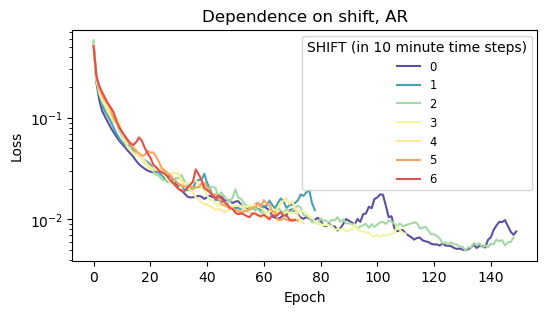

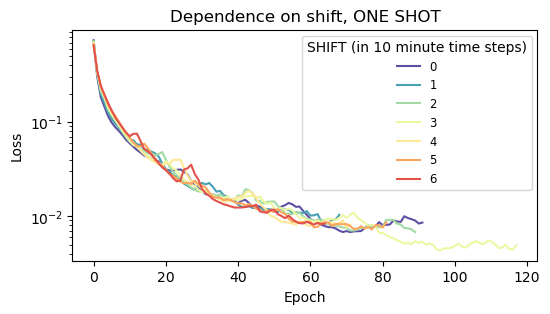

In [6]:
plt.title('Dependence on shift, AR')
SHIFT =  [0,1,2,3,4,5,6]
color = iter(cm.Spectral_r(np.linspace(0, 1, len(SHIFT)+1)))
for i in range(len(history_differentshiftAR)):
    OUT_STEPS=6
    c =next(color)
    plt.plot(history_differentshiftAR[i].history['loss'], label=SHIFT[i], color=c)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.yscale('log')
legend = plt.legend(title="SHIFT (in 10 minute time steps)",
                    loc=1, fontsize='small', fancybox=True)
plt.show()

plt.title('Dependence on shift, ONE SHOT')
SHIFT =  [0,1,2,3,4,5,6]
color = iter(cm.Spectral_r(np.linspace(0, 1, len(SHIFT)+1)))
for i in range(len(history_differentshiftoneshot)):
    c =next(color)
    plt.plot(history_differentshiftoneshot[i].history['loss'], label=SHIFT[i], color=c)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.yscale('log')
legend = plt.legend(title="SHIFT (in 10 minute time steps)",
                    loc=1, fontsize='small', fancybox=True)
plt.show()

In [7]:
history_differentstepsAR=[]
history_differentstepsoneshot=[]
for OUT_STEPS in [1,3,6,9,12]:
    SHIFT=2
    windows_differentsteps, num_features = windows_propagating,num_features=create_windows(station_input='dakar_and_pout',
                                           all_data=dfAveraged,
                                           time_indices=time_indices_split,
                                           #input_columns = all_input_columns,
                                           IN_WIDTH=IN_WIDTH,
                                           OUT_STEPS=OUT_STEPS,
                                           SHIFT=SHIFT)
    
    define_models(OUT_STEPS, num_features, lstm_units=200)
    ARlstm=get_model('AR lstm')
    lstm=get_model('lstm')
    historyARlstm=compile_and_fit(ARlstm,windows_differentsteps)
    historylstm=compile_and_fit(lstm,windows_differentsteps)

    history_differentstepsAR.append(historyARlstm)
    history_differentstepsoneshot.append(historylstm)


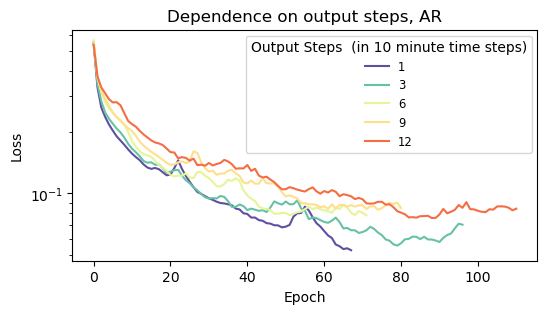

In [8]:
plt.title('Dependence on output steps, AR')
OUT_STEPS =  [1,3,6,9,12]
color = iter(cm.Spectral_r(np.linspace(0, 1, len(OUT_STEPS)+1)))
for i in range(len(history_differentstepsAR)):
    c =next(color)
    plt.plot(history_differentstepsAR[i].history['mean_absolute_error'], label=OUT_STEPS[i], color=c)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.yscale('log')
legend = plt.legend(title="Output Steps  (in 10 minute time steps)",
                    loc=1, fontsize='small', fancybox=True)
plt.show()



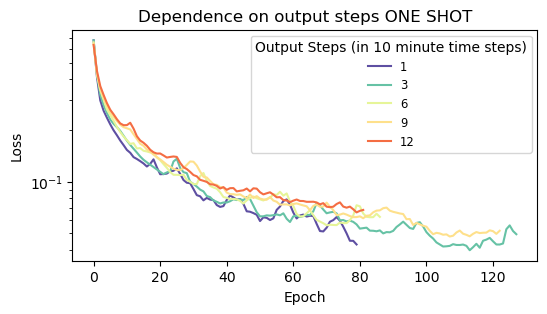

In [9]:
plt.title('Dependence on output steps ONE SHOT')
OUT_STEPS =  [1,3,6,9,12]
color = iter(cm.Spectral_r(np.linspace(0, 1, len(OUT_STEPS)+1)))
for i in range(len(history_differentstepsoneshot)):
    c =next(color)
    plt.plot(history_differentstepsoneshot[i].history['mean_absolute_error'], label=OUT_STEPS[i], color=c)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.yscale('log')
legend = plt.legend(title="Output Steps (in 10 minute time steps)",
                    loc=1, fontsize='small', fancybox=True)

plt.show()

In [10]:
history_differentlocationsAR=[]
history_differentlocationssoneshot=[]
for locations in ['dakar_and_pout','dakar','pout']:
    SHIFT=2
    OUT_STEPS=6
    windows_differentlocations, num_features = windows_propagating,num_features=create_windows(station_input=locations,
                                           all_data=dfAveraged,
                                           time_indices=time_indices_split,
                                           #input_columns = all_input_columns,
                                           IN_WIDTH=IN_WIDTH,
                                           OUT_STEPS=OUT_STEPS,
                                           SHIFT=SHIFT)
    
    define_models(OUT_STEPS, num_features, lstm_units=200)
    ARlstm=get_model('AR lstm')
    lstm=get_model('lstm')
    historyARlstm=compile_and_fit(ARlstm,windows_differentlocations)
    historylstm=compile_and_fit(lstm,windows_differentlocations)

    history_differentlocationsAR.append(historyARlstm)
    history_differentlocationssoneshot.append(historylstm)

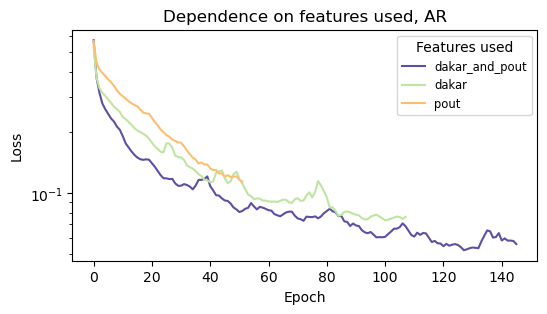

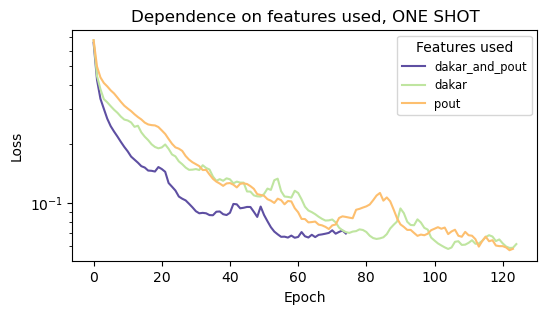

In [11]:
plt.title('Dependence on features used, AR')
locations = ['dakar_and_pout','dakar','pout']
color = iter(cm.Spectral_r(np.linspace(0, 1, len(locations)+1)))
for i in range(len(history_differentlocationsAR)):
    c =next(color)
    plt.plot(history_differentlocationsAR[i].history['mean_absolute_error'], label=locations[i], color=c)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.yscale('log')
legend = plt.legend(title="Features used",
                    loc=1, fontsize='small', fancybox=True)
plt.show()

plt.title('Dependence on features used, ONE SHOT')
locations = ['dakar_and_pout','dakar','pout']
color = iter(cm.Spectral_r(np.linspace(0, 1, len(locations)+1)))
for i in range(len(history_differentlocationssoneshot)):
    c =next(color)
    plt.plot(history_differentlocationssoneshot[i].history['mean_absolute_error'], label=locations[i], color=c)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.yscale('log')
legend = plt.legend(title="Features used",
                    loc=1, fontsize='small', fancybox=True)
plt.show()